## EE4802 - Learning From Data - House Price Prediction

Canvas link: https://canvas.nus.edu.sg/courses/38874/assignments/26718

#### Project Specification

Propose a model that can help the general public determine a fair price for a resale flat that he/she plans to buy/sale based on data available in the url below. Note that transaction prices from as early as 1990 are available.

https://data.gov.sg/dataset/resale-flat-prices Links to an external site.

Deliverables:

- Report (pdf)
- Data file (csv or xlsx)
- Python code (jpynb) => File -> Download -> Download .jpynb
 

Report guide (max 5 pages):

- Data and data preparation
- Models and model selection
- How to use proposed model to determine fair price
- Discussions
 
Grading Rubrics

- Appropriateness of analysis 20%
- Depth of analysis 30%
- Applicability and insights 30%
- Report writing 20%

The libraries we will be using are:

NOTE: some of these modules have dependency conflicts with different versions. Highly reccommend installing using conda to solve the requirements correctly. Updating all to newest version will give errors.

In [2]:
# https://towardsdatascience.com/principal-component-regression-clearly-explained-and-implemented-608471530a2f

import requests
import json
import os
import warnings
import sys
import logging

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from PyQt5 import QtCore, QtGui, QtWidgets
import plotly.express as px
import joblib

from sklearn.preprocessing import scale, normalize, PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA

import matplotlib_inline.backend_inline

pd.set_option('display.max_rows', 50)       # allow viewing more rows in output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


First, we will download the dataset from the data.gov.sg website. This can be done using their API. The result will be stored locally in a JSON file (size ~ 44 MB)

In [2]:
BASE_URL = 'https://data.gov.sg/api/action/datastore_search'
SRC_FILENAME = 'full_dataset.json'

# read data from oldest to newest
urls = {
    '2012-14': '?resource_id=83b2fc37-ce8c-4df4-968b-370fd818138b&limit=52203',
    '2015-16': '?resource_id=1b702208-44bf-4829-b620-4615ee19b57c&limit=37153',
    '2017-onwards': '?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=144880',
}

# don't re-download if we already have it
if not os.path.exists(SRC_FILENAME):
    print('Downloading dataset from the internet (44 MB)...')
    dataset = []
    for name, url in urls.items():
        fileobj = requests.get(BASE_URL + url).json()
        relevant_data = fileobj['result']['records']  # extract data fields
        dataset += relevant_data  # collect all files together

    with open(SRC_FILENAME, 'w') as f:
        json.dump(dataset, f)  # write whole dataset to one file

    print('Dataset downloaded.')
else:
    print('File already exists')

File already exists


Now we can load the file and read it. We will drop the `remaining_lease` column, as data from 2017 onwards does not have it. We also drop irrelevant labels.

In [19]:
SRC_FILENAME = 'full_dataset.json'

df = pd.read_json(SRC_FILENAME)
df.drop('remaining_lease', axis=1, inplace=True)
df.drop('_id', axis=1, inplace=True)
df.drop('storey_range', axis=1, inplace=True)
df.tail()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,block
234231,YISHUN,5 ROOM,Improved,122.0,YISHUN ST 22,495000.0,2023-01,1987,272
234232,YISHUN,5 ROOM,Improved,113.0,YISHUN ST 51,691800.0,2023-01,2018,513D
234233,YISHUN,5 ROOM,Improved,113.0,YISHUN ST 51,650000.0,2023-01,2017,512C
234234,YISHUN,5 ROOM,Improved,122.0,YISHUN ST 72,548000.0,2023-01,1987,760
234235,YISHUN,EXECUTIVE,Maisonette,145.0,YISHUN AVE 11,755000.0,2023-01,1988,344


To visualise the geographic distributions, we will lookup the addresses of these houses using an API.
This takes a very long time to run, so we store the results and just load the file now.

In [20]:
logging.basicConfig(filename='coords.log', encoding='utf-8')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

index_counter = -1

def get_coordinates(address):
    req = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    response = json.loads(req.text)
    if len(response['results']) > 0:
        return response['results'][0]['LATITUDE'], response['results'][0]['LONGITUDE']
    else:
        logger.error(f'Could not find coordinates at address {address}.')

def get_address_from_row(r):

    global index_counter
    index_counter += 1

    if index_counter % 100 == 0:
        logger.info(f'Found first {index_counter} addresses.')

    try:
        return f"{r['block']} {r['street_name']}"
    except KeyError:
        logger.error(f'Could not split row {index_counter} into block and street name.')

SRC_FILENAME = 'full_dataset_modified.json'
if not os.path.exists(SRC_FILENAME):
    df['lat_long'] = df.apply(lambda r: get_coordinates(get_address_from_row(r)), axis=1)
    df.to_json('full_dataset_modified.json')
else:
    print('File already exists.')

File already exists.


## Can Start Running Cells From Here

Pre-process the data:

In [3]:
df = pd.read_json('full_dataset_modified.json')
df.dropna(inplace=True)

# split lat_long into lat and long
df = pd.concat([df, pd.DataFrame(df['lat_long'].to_list(), columns=['lat', 'long'])], axis=1)
df['lat'] = df['lat'].astype(float)
df['long'] = df['long'].astype(float)

# one-hot encoding of town
# df = pd.concat([df, pd.get_dummies(df['town'], prefix='town')], axis=1)

# ordinal encoding of flat type
flat_type_mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4,
    '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}
df['flat_type_rank'] = df['flat_type'].replace(flat_type_mapping)

# ordinal encoding of flat model and town based on mean value
mean_vals_by_flat_model = df.groupby('flat_model')['resale_price'].mean()
df['flat_model_rank'] = df['flat_model'].replace(mean_vals_by_flat_model.rank())

mean_vals_by_town = df.groupby('town')['resale_price'].mean()
df['town_rank'] = df['town'].replace(mean_vals_by_town.rank())

# convert month to months since Jan 2012
df['month'] = pd.to_datetime(df['month'], yearfirst=True)
df['months_since_2012'] = df['month'].apply(lambda d: (d.year - 2012) * 12 + d.month)

# calculate age of house in years at sell date since lease start
df['age_years'] = df.apply(lambda x: x['month'].year - x['lease_commence_date'], axis=1)

# drop edited and unused columns
df.drop('town', axis=1, inplace=True)
df.drop('flat_type', axis=1, inplace=True)
df.drop('flat_model', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('street_name', axis=1, inplace=True)
df.drop('block', axis=1, inplace=True)
df.drop('lat_long', axis=1, inplace=True)
df.dropna(inplace=True)

# move resale_price to end
resale_price_col = df.pop('resale_price')
df.insert(len(df.axes[1]), "resale_price", resale_price_col)

df.head()

,floor_area_sqm,lease_commence_date,lat,long,flat_type_rank,flat_model_rank,town_rank,months_since_2012,age_years,resale_price
0,45.0,1986.0,1.374694,103.836463,2.0,7.0,5.0,3.0,26.0,250000.0
1,44.0,1980.0,1.373401,103.849073,2.0,7.0,5.0,3.0,32.0,265000.0
2,68.0,1980.0,1.379395,103.839157,3.0,2.0,5.0,3.0,32.0,315000.0
3,67.0,1984.0,1.362758,103.858015,3.0,2.0,5.0,3.0,28.0,320000.0
4,67.0,1980.0,1.379867,103.835977,3.0,2.0,5.0,3.0,32.0,321000.0


Investigate - report, map:

In [ ]:
ProfileReport(df)

import plotly.express as px
fig = px.density_mapbox(df, lat='lat', lon='long', z='resale_price', radius=4,
                        center=dict(lat=1.35, lon=103.8), zoom=9.5,
                        mapbox_style="stamen-terrain")
fig.show()

Compute reference MSE values for plain (no PCA) regressions.

In [8]:
X = df.drop('resale_price', axis=1)
y = df['resale_price']

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)  # new variables are [a, b, a^2, ab, b^2, ... (all combinations)]

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

cv = KFold(n_splits=10, shuffle=True)

# Linear Regression - plain
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

# Lasso Regression - plain
lasso_reg = LassoCV().fit(X_train_scaled, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

# Ridge Regression - plain
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

print(lr_score_test, lasso_score_test, ridge_score_test)

32420956.511959203 67673.83050972295 60158.863371640575


Test all models using PCA:

In [ ]:
# Generate all the principal components
pca = PCA()  # Default n_components = min(n_samples, n_features)
lin_reg = LinearRegression()

cum_vars = {1: None, 2: None, 3: None}
rmse_scores = {1: None, 2: None, 3: None}

for d in (1, 2, 3):
    # check PCA scores
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)  # new variables are [a, b, a^2, ab, b^2, ... (all combinations)]
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)
    X_train_pc = pca.fit_transform(X_train_scaled)
    cum_vars[d] = [sum(pca.explained_variance_ratio_[:i + 1])
        for i in range(len(pca.explained_variance_ratio_))]
    
    print(f'Found variances for degree {d}.')

    # check model accuracy
    scores = []
    for i in range(X_train_pc.shape[1]):
        score = -1 * cross_val_score(lin_reg, 
                             X_train_pc[:, :i + 1], # Use first k principal components
                             y_train, 
                             cv=cv, 
                             scoring='neg_root_mean_squared_error').mean()
        if i % 10 == 0:
            print(f'Found accuracy for degree {d} ({i} / {X_train_pc.shape[1]} done)')
        scores.append(score)
    rmse_scores[d] = scores

Make PCA scree plots:

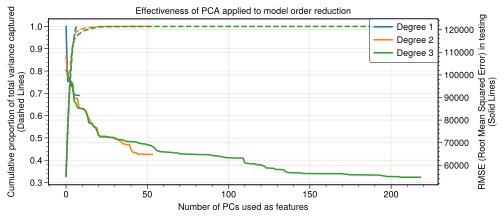

In [70]:
fig, ax = plt.subplots(figsize=(7,3))

ax.set_xlabel('Number of PCs used as features')
ax.set_ylabel('Cumulative proportion of total variance captured\n(Dashed Lines)')
plt.style.use(r'C:\Users\lnick\Documents\Personal\Programming\Python\Resources\proplot_style.mplstyle')
plt.title('Effectiveness of PCA applied to model order reduction')

ax.plot([0], [0.5], color='black', linestyle='dashed', label='Variance')
ax.plot([0], [0.5], color='black', label='Error')

for i in (1, 2, 3):
    ax.plot(list(range(len(cum_vars[i]))), cum_vars[i], label=f'Degree {i}', linestyle='dashed')

ax2 = ax.twinx()

for i in (1, 2, 3):
    ax2.plot(list(range(len(rmse_scores[i]))), rmse_scores[i], label=f'Degree {i}')

ax2.set_ylabel('RMSE (Root Mean Squared Error) in testing\n(Solid Lines)')

plt.legend(loc='upper right')
plt.show()

Build desired model:

In [9]:
# Visually determine optimal number of principal components
best_pc_num = 136

# Train model with first 9 principal components
pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 9 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print(pcr_score_test)

57619.80297829292


Save model parameters for easy access later:

In [26]:
mean_std_arr = np.array([X_poly.mean(axis=0), X_poly.std(axis=0)])
np.save('mean_std_arr.npy', mean_std_arr)
np.save('pca_components.npy', pca.components_.T[:, :best_pc_num])
np.save('lin_reg_int_coef.npy', [lin_reg_pc.intercept_, lin_reg_pc.coef_])

Make a sample prediction:

In [27]:
def transform_and_predict(df_sample: pd.DataFrame) -> float:
    '''
    Takes an input containing the 9 numeric variables, preprocesses them and predicts the output.
    '''

    # generate polynomial features
    poly = PolynomialFeatures(degree=3, include_bias=False)
    df_sample_poly = poly.fit_transform(df_sample)

    # standardise wrt dataset means and variances
    means, std_devs = np.load('mean_std_arr.npy')
    df_sample_std = (df_sample_poly - means) / std_devs

    # transform to PC space
    pca_mat = np.load('pca_components.npy')
    df_sample_pc = df_sample_std @ pca_mat

    # make prediction
    intercept, coeff = np.load('lin_reg_int_coef.npy', allow_pickle=True)
    pred = intercept + coeff @ df_sample_pc.T
    return float(pred)


df_sample = pd.read_excel('test_data.xlsx')  # 1 x 9
pred = transform_and_predict(df_sample)
print(pred)

324750.41722097306
